In [1]:
# Import the neccesary libraries needed
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler 
import numpy as np
from numpy import insert
import os
import time

# keras tuner for hyperparameter tuning
import keras_tuner as kt

# tensorflow Libraries
import tensorflow as tf
from keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow import keras
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Activation, Dense, Dropout, LSTM
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import sparse_categorical_crossentropy
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.models import load_model

Import the CSV Training and Testing Data Sets

In [23]:
# Import the csv's (IMPORTANT: You need at least 16 Gb of RAM to proceed)

# Original Dataset
#train = pd.read_csv('D:\\OneDrive\\OneDrive - University of Massachusetts Dartmouth\\ECE457_Senior_Design_ECE5\\CSV_Files\\PortTraining_1404_002_FINAL_startingAt24.csv')
#test = pd.read_csv('D:\\OneDrive\\OneDrive - University of Massachusetts Dartmouth\\ECE457_Senior_Design_ECE5\\CSV_Files\\StbdTesting_1404_002_FINAL.csv')

# Deeper More Variate Dataset
#train38 = pd.read_csv('D:\\OneDrive\\OneDrive - University of Massachusetts Dartmouth\\ECE457_Senior_Design_ECE5\\CSV_Files\\0001_1404.038_port.csv')
#test38 = pd.read_csv('D:\\OneDrive\\OneDrive - University of Massachusetts Dartmouth\\ECE457_Senior_Design_ECE5\\CSV_Files\\0001_1404.038_stbd.csv')

# Noise Reduction RAW Dataset
#train = pd.read_csv('D:\\OneDrive\\OneDrive - University of Massachusetts Dartmouth\\ECE457_Senior_Design_ECE5\\CSV_Files\\0001_1404.002NR_port.csv')
#test = pd.read_csv('D:\\OneDrive\\OneDrive - University of Massachusetts Dartmouth\\ECE457_Senior_Design_ECE5\\CSV_Files\\0001_1404.002NR_stbd.csv')

# Noise Reduction Dataset
train = pd.read_csv('D:\\OneDrive\\OneDrive - University of Massachusetts Dartmouth\\ECE457_Senior_Design_ECE5\\CSV_Files\\0001_1404.038_port_FinalCleaned_RollReady.csv')
train2 = pd.read_csv('D:\\OneDrive\\OneDrive - University of Massachusetts Dartmouth\\ECE457_Senior_Design_ECE5\\CSV_Files\\0001_1404.002_port_FinalCleaned_RollReady.csv')
test = pd.read_csv('D:\\OneDrive\\OneDrive - University of Massachusetts Dartmouth\\ECE457_Senior_Design_ECE5\\CSV_Files\\0001_1404.038_stbd_FinalCleaned_RollReady.csv')
test2 = pd.read_csv('D:\\OneDrive\\OneDrive - University of Massachusetts Dartmouth\\ECE457_Senior_Design_ECE5\\CSV_Files\\0001_1404.002_stbd_FinalCleaned_RollReady.csv')

#train = pd.read_csv('D:\\OneDrive\\OneDrive - University of Massachusetts Dartmouth\\ECE457_Senior_Design_ECE5\\CSV_Files\\repackingTestFiles\\0001_1404.038_port_new.csv')
#test = pd.read_csv('D:\\OneDrive\\OneDrive - University of Massachusetts Dartmouth\\ECE457_Senior_Design_ECE5\\CSV_Files\\repackingTestFiles\\0001_1404.038_stbd_new.csv')

In [ ]:
train

In [ ]:
test

Split up the Features and Labels from both the Training and Testing Datasets

In [24]:
# Split up the features and labels from both the training and testing datasets
#x_train=train.iloc[:,4:24]

#x_train=train.iloc[:,3:24] # sample time delay through Q10

x_train1=train.iloc[:,3:25] # sample time delay through roll
x_train2 = train2.iloc[:, 3:25]
#x_train=train38.iloc[:,3:24]

x_train1['Amplitude']=train.iloc[:,29]
x_train2['Amplitude']=train2.iloc[:,29]
#x_train['Amplitude']=train38.iloc[:,29]


#x_test=test.iloc[:,4:24]
#x_test=test.iloc[:,3:24]    # sample time delay through Q10

x_test=test.iloc[:,3:25]    # sample time delay through roll
x_test2=test2.iloc[:,3:25]    # sample time delay through roll
#x_test['Roll'] = x_test['Roll']


x_test['Amplitude']=test.iloc[:,29]
x_test2['Amplitude']=test2.iloc[:,29]
#x_test['Amplitude']=test38.iloc[:,29]

y_train1=train.iloc[:,26]
y_train2=train2.iloc[:,26]
#y_train=train38.iloc[:,26]

y_test=test.iloc[:,26]
y_test2=test2.iloc[:,26]
#y_test=test38.iloc[:,26]

In [26]:
xframes = [x_train1, x_train2]
x_train = pd.concat(xframes, sort=False)
yframes = [y_train1, y_train2]
y_train = pd.concat(yframes, sort=False)

In [ ]:
y_test

In [ ]:
x_train

In [ ]:
x_test

Scale the Features from -1 to 1 so that Training is Easier for the Model

In [43]:
# Scale the Features and Labels from [-1,1]

s1=MinMaxScaler(feature_range=(0,1))
#s1=MinMaxScaler(feature_range=(0,1))
x_train_scale=s1.fit_transform(x_train)

#s2=MinMaxScaler(feature_range=(0,1))
#s2=MinMaxScaler(feature_range=(0,1))
x_test_scale=s1.transform(x_test)
x_test_scale=x_test_scale
x_test_scale[:, 21] = -x_test_scale[:, 21]
x_test2_scale=s1.transform(x_test2)
x_test2_scale[:, 21] = -x_test2_scale[:, 21]

# Scale DOA's from (0 to 1)
#s3=MinMaxScaler(feature_range=(0,1))
#y_train_scale = s3.fit_transform(train[['DOA']])
y_train_scale= y_train.to_numpy()

#s4=MinMaxScaler(feature_range=(0,1))
#y_test_scale = s4.fit_transform(test[['DOA']])
y_test_scale = y_test.to_numpy()
y_test2_scale = y_test2.to_numpy()
print(len(x_train_scale))
print(len(y_train_scale))

7622237
7622237


In [9]:
x_train_scale

array([[0.03403601, 0.55510042, 0.49083105, ..., 0.44995814, 0.59866221,
        0.19230769],
       [0.0342556 , 0.55140201, 0.47341079, ..., 0.48352091, 0.59866221,
        0.22115385],
       [0.03469477, 0.54222229, 0.48473322, ..., 0.44795833, 0.59866221,
        0.40384615],
       ...,
       [0.99956083, 0.54172131, 0.47597129, ..., 0.49746535, 0.42474916,
        0.17307692],
       [0.99978041, 0.56875949, 0.48050026, ..., 0.4655846 , 0.42474916,
        0.20192308],
       [1.        , 0.57017402, 0.4762377 , ..., 0.44933805, 0.42474916,
        0.21153846]])

In [7]:
x_train_scale[:,21]

array([0.59866221, 0.59866221, 0.59866221, ..., 0.42474916, 0.42474916,
       0.42474916])

In [8]:
x_test_scale[:,21]

array([-0.59866221, -0.59866221, -0.59866221, ..., -0.42474916,
       -0.42474916, -0.42474916])

In [ ]:
y_train_scale

In [ ]:
Test_DOA_df= pd.DataFrame(y_test_scale, columns=['TEST DOAs'])
Test_DOA_df


In [ ]:
Test_DOA_df.describe()

In [10]:
df= pd.DataFrame(x_train_scale, columns= ['TWTT','I1', 'Q1', 'I2', 'Q2', 'I3', 'Q3', 'I4', 'Q4', 'I5', 'Q5', 'I6', 'Q6', 'I7', 'Q7', 'I8', 'Q8', 'I9', 'Q9', 'I10', 'Q10','Roll', 'Amplitude'])
df


,TWTT,I1,Q1,I2,Q2,I3,Q3,I4,Q4,I5,...,I7,Q7,I8,Q8,I9,Q9,I10,Q10,Roll,Amplitude
0,0.034036,0.555100,0.490831,0.478568,0.419284,0.604678,0.503978,0.500413,0.625890,0.401728,...,0.457680,0.513242,0.447324,0.481483,0.493715,0.458495,0.565826,0.449958,0.598662,0.192308
1,0.034256,0.551402,0.473411,0.494694,0.431328,0.584435,0.505259,0.520081,0.613071,0.391703,...,0.477378,0.531799,0.423836,0.474472,0.518744,0.445072,0.551515,0.483521,0.598662,0.221154
2,0.034695,0.542222,0.484733,0.495606,0.419734,0.592157,0.514239,0.503458,0.615363,0.408393,...,0.465466,0.506474,0.449248,0.493261,0.480671,0.452228,0.577205,0.447958,0.598662,0.403846
3,0.034914,0.548131,0.524562,0.456328,0.385222,0.639724,0.523520,0.460322,0.634240,0.420130,...,0.426706,0.488977,0.479840,0.482797,0.468291,0.482013,0.567934,0.405838,0.598662,0.125000
4,0.035134,0.570660,0.507896,0.445567,0.414553,0.630493,0.491532,0.489981,0.648981,0.385926,...,0.423537,0.528995,0.459713,0.441188,0.515175,0.486436,0.523744,0.432921,0.598662,0.201923
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3635094,0.999122,0.537242,0.470199,0.500493,0.448367,0.576555,0.504791,0.532590,0.614044,0.396330,...,0.477472,0.523853,0.413423,0.479178,0.513715,0.447315,0.560177,0.487466,0.424749,0.125000
3635095,0.999341,0.530803,0.474832,0.497041,0.457806,0.582730,0.516499,0.548245,0.613397,0.402153,...,0.464308,0.525200,0.406925,0.488853,0.512894,0.456697,0.569644,0.495915,0.424749,0.163462
3635096,0.999561,0.541721,0.475971,0.499985,0.453488,0.586270,0.515542,0.549547,0.605950,0.393161,...,0.466414,0.535260,0.414076,0.489291,0.511125,0.456786,0.574793,0.497465,0.424749,0.173077
3635097,0.999780,0.568759,0.480500,0.522404,0.436052,0.587227,0.483260,0.522265,0.590121,0.366171,...,0.485490,0.555638,0.439145,0.488318,0.529601,0.438315,0.566238,0.465585,0.424749,0.201923


In [ ]:
df.describe()

Shift the DOA's to the Left by one so that the Current I and Q data Align with the current DOA while using TimeSeriesGenerator to Window the Data

In [31]:
# Shift the DOA to the left by one to use the current DOA label with the current I and Q data.
# Normally the TimeseriesGenerator function uses past values to predict the future but we would like current data to help predict the current samples' DOA
print(len(y_train_scale))
print(len(y_test_scale))
y_train_scale=insert(y_train_scale, 0, 0)
y_train_scale=np.delete(y_train_scale, -1)
y_test_scale=insert(y_test_scale, 0,0)
y_test_scale=np.delete(y_test_scale, -1)
y_test2_scale=insert(y_test2_scale, 0,0)
y_test2_scale=np.delete(y_test2_scale, -1)
print(y_train_scale)
print(len(y_train_scale))
print(y_test_scale)
print(len(y_test_scale))

7622237
3382112
[ 0.00000000e+00 -3.05400003e+00 -5.40000005e-02 ...  8.02140007e+01
  8.02440007e+01  8.02680007e+01]
7622237
[ 0.          3.69000003  2.39400002 ... 76.59600067 76.35000066
 76.32600066]
3382112


Create the Windows Neccesary for the LSTM model using the TimeSeriesGenerator Function

In [85]:
# Create the windows neccesary for the LSTM model within tensorflow keras
# Below are the arguments of the timeseries_dataset_from_array function
# The function takes a numpy array and makes a timeseries out of it
NumSampsPerPing= 4301-24+1
data=x_train_scale # the data to make the windows
targets=y_train_scale # time steps in the data (don't need)
sequence_length=25 # window length
sequence_stride=1# period between successive output sequences
sampling_rate=1 # period between successive individual timesteps     within sequences
batch_size=32 # number of time series samples in each batch
shuffle=False #shuffle the data before making the windows
seed=None # is related to shuffle
start_index=None # is related to shuffle
end_index=None # is related to shuffle
n_features=23

test_data=x_test_scale
test_targets=y_test_scale
test2_data = x_test2_scale
test2_targets = y_test2_scale
dataRows = data.shape[0]
dataRows

7622237

In [86]:
#validationStartRow = dataRows - NumSampsPerPing*281
validationStartRow = dataRows - 200*1000
#validationStartRow = dataRows - 8*1000

print(validationStartRow, ',',dataRows)

train_data = data[:validationStartRow-1]
#train_data = data
#   train_data.shape[0]
train_targets = targets[:validationStartRow-1]
#train_targets = targets
#   train_targets.shape[0]
val_data = data[validationStartRow:]
#   val_data.shape[0], dataRows-validationStartRow
y_val_scale = y_train_scale[validationStartRow:]

val_targets = targets[validationStartRow:]

7422237 , 7622237


In [ ]:
train_data.shape , train_targets.shape

In [ ]:
val_data.shape , val_targets.shape

In [87]:


#inputs=TimeseriesGenerator(data, targets,sequence_length, batch_size)
train_inputs=TimeseriesGenerator(data=train_data,targets=train_targets,length=sequence_length,sampling_rate=sampling_rate,stride=sequence_stride,batch_size=batch_size, shuffle=True)
trainentire_inputs = TimeseriesGenerator(data=data,targets=targets,length=sequence_length,sampling_rate=sampling_rate,stride=sequence_stride,batch_size=256)

val_inputs = TimeseriesGenerator(data=val_data,targets=val_targets,length=sequence_length,sampling_rate=sampling_rate,stride=sequence_stride,batch_size=256, shuffle=False)

#test_inputs=TimeseriesGenerator(test_data[0:40000], -1*test_targets[0:40000],sequence_length, batch_size)
test_inputs=TimeseriesGenerator(data=test_data,targets=test_targets,length=sequence_length,sampling_rate=sampling_rate,stride=sequence_stride,batch_size=256)
test_inputs2=TimeseriesGenerator(data=test2_data,targets=test2_targets,length=sequence_length,sampling_rate=sampling_rate,stride=sequence_stride,batch_size=256)

#inputs=tf.keras.preprocessing.timeseries_dataset_from_array(data, targets, sequence_length, sequence_stride, sampling_rate, batch_size, shuffle)
#print(type(inputs))

#print('done')

In [ ]:
# abstraction test imports
abstraction_test_port = pd.read_csv('D:\\OneDrive\\OneDrive - University of Massachusetts Dartmouth\\ECE457_Senior_Design_ECE5\\CSV_Files\\0001_1404.038_port.csv')
abstraction_test_stbd = pd.read_csv('D:\\OneDrive\\OneDrive - University of Massachusetts Dartmouth\\ECE457_Senior_Design_ECE5\\CSV_Files\\0001_1404.038_stbd.csv')
# Split up the features and labels from both the training and testing datasets
#x_train=train.iloc[:,4:24]

Xatest_port=abstraction_test_port.iloc[:,3:24]
#x_train['TWTT']=train.iloc[:,28]  I feel as though the TWTT has NO impact on the DOA so we should NOT include it in training
Xatest_port['Amplitude']=abstraction_test_port.iloc[:,29]


#x_test=test.iloc[:,4:24]
Xatest_stbd=abstraction_test_stbd.iloc[:,3:24]
#x_test['TWTT']=test.iloc[:,28] I feel as though the TWTT has NO impact on the DOA so we should NOT include it in training
Xatest_stbd['Amplitude']=abstraction_test_stbd.iloc[:,29]

Yatest_port=abstraction_test_port.iloc[:,26]

Yatest_stbd=abstraction_test_stbd.iloc[:,26]

s10=MinMaxScaler(feature_range=(0,1))
#s1=MinMaxScaler(feature_range=(0,1))
Xatest_port_scale=s10.fit_transform(Xatest_port)

s20=MinMaxScaler(feature_range=(0,1))
#s2=MinMaxScaler(feature_range=(0,1))
Xatest_stbd_scale=s20.fit_transform(Xatest_stbd)
#x_test_scale=x_test_scale

# Scale DOA's from (0 to 1)
s30=MinMaxScaler(feature_range=(0,1))
#y_train_scale = s3.fit_transform(train[['DOA']])
Yatest_port_scale= Yatest_port.to_numpy()

s40=MinMaxScaler(feature_range=(0,1))
#y_test_scale = s4.fit_transform(test[['DOA']])
Yatest_stbd_scale= Yatest_stbd.to_numpy()

print(len(Xatest_port_scale))
print(len(Xatest_stbd_scale))

print(len(Yatest_port_scale))
print(len(Yatest_stbd_scale))
Yatest_port_scale=insert(Yatest_port_scale, 0, 0)
Yatest_port_scale=np.delete(Yatest_port_scale, -1)
Yatest_stbd_scale=insert(Yatest_stbd_scale, 0,0)
Yatest_stbd_scale=np.delete(Yatest_stbd_scale, -1)
print(Yatest_port_scale)
print(len(Yatest_port_scale))
print(Yatest_stbd_scale)
print(len(Yatest_stbd_scale))


abstraction_test_port_inputs=TimeseriesGenerator(data=Xatest_port_scale,targets=Yatest_port_scale,length=sequence_length,sampling_rate=sampling_rate,stride=sequence_stride,batch_size=batch_size)
abstraction_test_stbd_inputs=TimeseriesGenerator(data=Xatest_stbd_scale,targets=Yatest_stbd_scale,length=sequence_length,sampling_rate=sampling_rate,stride=sequence_stride,batch_size=batch_size)




In [ ]:
# print the first couple of samples to see if everything is lining up
for i in range(100):
	x, y = train_inputs[i]
	print('%s => %s' % (x, y))

In [ ]:
# print the first couple of samples to see if everything everything is lining up
for i in range(100):
	x, y = test_inputs[i]
	print('%s => %s' % (x, y))

Define the Model's Structure

In [ ]:
# clear the model!
model = 0

In [88]:
# With all the preproccessing done, it is time to define the model
# Define the LSTM Model
model= Sequential(name='MLDOASequential')
model.add(LSTM(units=96, name='LSTM1', activation='tanh', input_shape=(sequence_length,n_features), return_sequences=True))
model.add(LSTM(units=96, name='LSTM2', activation='tanh', input_shape=(sequence_length,n_features), return_sequences=False))
#model.add(LSTM(units=44, name='LSTM1', activation='tanh', input_shape=(sequence_length,n_features), return_sequences=False))

#model.add(LSTM(units=64, name='LSTM1', activation='tanh', batch_input_shape=(batch_size, sequence_length, n_features),input_shape=(sequence_length,n_features), return_sequences=True, stateful=False, bias_initializer='ones'))
#model.add(LSTM(units=64, name='LSTM1', activation='tanh', input_shape=(sequence_length,n_features), return_sequences=True, stateful=False, bias_initializer='Ones'))
#model.add(Dense(units=))
#model.add(Dense(units=300, name='Dense1', activation = 'relu'))
#model.add(Dropout(0.2, name='Dropout1'))

#model.add(LSTM(units=416, name='LSTM2', activation='tanh', return_sequences=True, stateful=False, bias_initializer='ones'))
#model.add(Dense(units=500, name='Dense2'))
#model.add(Dense(units=100, activation='relu'))
#model.add(Dropout(0.1, name='Dropout2'))

#model.add(LSTM(units=312, name='LSTM3', activation='tanh', return_sequences=False, stateful=False, bias_initializer='Ones'))
#model.add(Dense(units=300, name='Dense3', activation='relu'))

#model.add(Dropout(0.3, name='Dropout1'))

#model.add(Dense(units=10, name='Dense4', activation='relu', input_shape=(sequence_length,n_features)))
model.add(Dense(units=392, name='Dense1', activation='relu'))
#model.add(Dropout(0.2, name='Dropout2'))
model.add(Dense(units=192, name='Dense2', activation='relu'))
#model.add(Dropout(0.3, name='Dropout3'))
#model.add(Dense(units=96, name='Dense3', activation='relu'))
#model.add(Dropout(0.2, name='Dropout3'))
#model.add(Dense(units=30, name='Dense4', activation='relu'))
#model.add(Dropout(0.2, name='Dropout4'))
#model.add(Dense(units=30, name='Dense5', activation='relu'))
#model.add(Dropout(0.2, name='Dropout5'))
#model.add(Dense(units=10, name='Dense9', activation='relu'))
#model.add(Dropout(0.2, name='Dropout6'))
#model.add(LSTM(units=84, name='LSTM3', activation='tanh', return_sequences=True))
#model.add(Dense(units=100))
#model.add(Dense(units=100, activation = 'linear'))
#model.add(Dropout(0.2))
#model.add(LSTM(units=320, activation='tanh', return_sequences=True))
#model.add(Dropout(0.2))
#model.add(LSTM(units=168, name='LSTM4', activation='tanh'))
#model.add(Dense(units=100))
#model.add(Dense(units=100, activation = 'linear'))
#model.add(Dropout(0.2))
#model.add(LSTM(units=480))
#model.add(Dropout(0.2))


model.add(Dense(units=1, name='DenseOutput', activation='linear')) #one output (namely: DOA)



In [89]:
model.summary()

Model: "MLDOASequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 LSTM1 (LSTM)                (None, 25, 96)            46080     
                                                                 
 LSTM2 (LSTM)                (None, 96)                74112     
                                                                 
 Dense1 (Dense)              (None, 392)               38024     
                                                                 
 Dense2 (Dense)              (None, 192)               75456     
                                                                 
 DenseOutput (Dense)         (None, 1)                 193       
                                                                 
Total params: 233,865
Trainable params: 233,865
Non-trainable params: 0
_________________________________________________________________


Train the Model using the Specified Hyperparmeters

In [19]:
# epoch learning rate scheduler for 10 epochs.
def EpochScheduler10_2(epoch, lr):
    if epoch == 0:
        return 0.1
    if epoch == 1:
        return 0.1
    elif epoch == 2:
        return 0.1
    elif epoch == 3:
        return 0.05
    elif epoch == 4:
        return 0.05
    elif epoch == 5:
        return 0.05
    elif epoch == 6:
        return 0.025
    elif epoch == 7:
        return 0.025
    elif epoch == 8:
        return 0.025
    elif epoch == 9:
        return 0.01
    elif epoch == 10:
        return 0.01
    elif epoch == 11:
        return 0.01
    else:
        return 0.01


In [18]:
# epoch learning rate scheduler for 10 epochs.
def EpochScheduler10(epoch, lr):
    if epoch == 0:
        return 0.01
    if epoch == 1:
        return 0.01
    elif epoch == 2:
        return 0.01
    elif epoch == 3:
        return 0.005
    elif epoch == 4:
        return 0.005
    elif epoch == 5:
        return 0.005
    elif epoch == 6:
        return 0.0025
    elif epoch == 7:
        return 0.0025
    elif epoch == 8:
        return 0.0025
    elif epoch == 9:
        return 0.001
    elif epoch == 10:
        return 0.001
    elif epoch == 11:
        return 0.001
    else:
        return 0.001


In [17]:
def scheduler(epoch,lr):
    if epoch<=1:
        return lr
    elif epoch>=2 | epoch<=4:
        #return lr/1.65
        return lr/1.55
    else:
        #return lr * tf.math.exp(-0.5)
        return lr * tf.math.exp(-0.2)

In [91]:
#Now it is time to train the model
#opt=tf.keras.optimizers.Adam(learning_rate=0.00007)#,decay=1e-5)
opt=tf.keras.optimizers.Adam(learning_rate=0.0002)#,decay=1e-5)
#opt = tf.keras.optimizers.Adam()
mMSE = tf.keras.metrics.MeanSquaredError()     # metric for Mean Squared Error
mRMSE = tf.keras.metrics.RootMeanSquaredError()
huberLoss = tf.keras.losses.Huber(delta=10)
#model.compile(loss='mse', optimizer=opt, metrics=[mMSE, mRMSE])
model.compile(loss=huberLoss, optimizer=opt, metrics=[mMSE, mRMSE])

# Allow for early stopping so that the model does not overfit the training dataset
#es= EarlyStopping(monitor='val_loss', mode='min',verbose=1,patience=10)
es= EarlyStopping(monitor='loss', mode='min',verbose=1,patience=10)
# change learning rates per epoch
lrCallback = tf.keras.callbacks.LearningRateScheduler(EpochScheduler10_2)
sc = tf.keras.callbacks.LearningRateScheduler(scheduler)
# Model Checkpoint to save good runs
#cp = ModelCheckpoint('model/', save_best_only=True)
cp = ModelCheckpoint('model/', monitor='loss',save_best_only=True)

t0=time.time()
#history= model.fit(inputs,steps_per_epoch=4000,epochs=200,verbose=1, callbacks=[es])
#history= model.fit(train_inputs, steps_per_epoch=4000, validation_data=val_inputs, epochs=100, callbacks=[lrCallback, cp])
#history= model.fit(train_inputs, epochs=1, batch_size=None,callbacks=[cp, es])
#history= model.fit(train_inputs, epochs=75, steps_per_epoch=1782, validation_steps=10720,validation_data=val_inputs, batch_size=None,callbacks=[cp])
#history= model.fit(train_inputs, epochs=15,validation_data=val_inputs, batch_size=None,callbacks=[cp, sc])

#history = model.fit(train_inputs, epochs = 60, steps_per_epoch = 1500, validation_data=val_inputs, batch_size=None,callbacks=[cp, es])
history = model.fit(train_inputs, epochs = 300, steps_per_epoch = 1500, batch_size=None,callbacks=[cp, es])

t1=time.time()
print("The total run time to train was %.2f seconds"%(t1-t0))

# plot the loss function


Epoch 1/300
1500/1500 [==============================] - ETA: 0s - loss: 22.8601 - mean_squared_error: 76.9875 - root_mean_squared_error: 8.7743

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


1500/1500 [==============================] - 23s 14ms/step - loss: 22.8601 - mean_squared_error: 76.9875 - root_mean_squared_error: 8.7743
Epoch 2/300
1500/1500 [==============================] - 14s 9ms/step - loss: 23.1313 - mean_squared_error: 78.1536 - root_mean_squared_error: 8.8405
Epoch 3/300
1495/1500 [============================>.] - ETA: 0s - loss: 21.9963 - mean_squared_error: 74.9268 - root_mean_squared_error: 8.6560

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


1500/1500 [==============================] - 21s 14ms/step - loss: 21.9959 - mean_squared_error: 74.9062 - root_mean_squared_error: 8.6548
Epoch 4/300
1500/1500 [==============================] - ETA: 0s - loss: 21.3913 - mean_squared_error: 72.9268 - root_mean_squared_error: 8.5397

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


1500/1500 [==============================] - 20s 13ms/step - loss: 21.3913 - mean_squared_error: 72.9268 - root_mean_squared_error: 8.5397
Epoch 5/300
1496/1500 [============================>.] - ETA: 0s - loss: 21.0559 - mean_squared_error: 71.8856 - root_mean_squared_error: 8.4785

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


1500/1500 [==============================] - 21s 14ms/step - loss: 21.0810 - mean_squared_error: 71.9734 - root_mean_squared_error: 8.4837
Epoch 6/300
1497/1500 [============================>.] - ETA: 0s - loss: 20.6303 - mean_squared_error: 69.6463 - root_mean_squared_error: 8.3454

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


1500/1500 [==============================] - 22s 15ms/step - loss: 20.6186 - mean_squared_error: 69.5956 - root_mean_squared_error: 8.3424
Epoch 7/300
1495/1500 [============================>.] - ETA: 0s - loss: 20.6145 - mean_squared_error: 70.0610 - root_mean_squared_error: 8.3702

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


1500/1500 [==============================] - 21s 14ms/step - loss: 20.6076 - mean_squared_error: 70.0052 - root_mean_squared_error: 8.3669
Epoch 8/300
1497/1500 [============================>.] - ETA: 0s - loss: 20.4570 - mean_squared_error: 69.0425 - root_mean_squared_error: 8.3092

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


1500/1500 [==============================] - 21s 14ms/step - loss: 20.4568 - mean_squared_error: 69.0356 - root_mean_squared_error: 8.3088
Epoch 9/300
1496/1500 [============================>.] - ETA: 0s - loss: 19.6045 - mean_squared_error: 66.3238 - root_mean_squared_error: 8.1439

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


1500/1500 [==============================] - 21s 14ms/step - loss: 19.5994 - mean_squared_error: 66.2919 - root_mean_squared_error: 8.1420
Epoch 10/300
1500/1500 [==============================] - 16s 10ms/step - loss: 19.6353 - mean_squared_error: 67.0864 - root_mean_squared_error: 8.1906
Epoch 11/300
1496/1500 [============================>.] - ETA: 0s - loss: 19.0648 - mean_squared_error: 65.3062 - root_mean_squared_error: 8.0812

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


1500/1500 [==============================] - 20s 14ms/step - loss: 19.0732 - mean_squared_error: 65.3548 - root_mean_squared_error: 8.0842
Epoch 12/300
1496/1500 [============================>.] - ETA: 0s - loss: 18.4889 - mean_squared_error: 61.5436 - root_mean_squared_error: 7.8450

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


1500/1500 [==============================] - 21s 14ms/step - loss: 18.5155 - mean_squared_error: 61.6367 - root_mean_squared_error: 7.8509
Epoch 13/300
1496/1500 [============================>.] - ETA: 0s - loss: 18.2877 - mean_squared_error: 60.7596 - root_mean_squared_error: 7.7948

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


1500/1500 [==============================] - 21s 14ms/step - loss: 18.2766 - mean_squared_error: 60.7291 - root_mean_squared_error: 7.7929
Epoch 14/300
1496/1500 [============================>.] - ETA: 0s - loss: 17.5934 - mean_squared_error: 60.1632 - root_mean_squared_error: 7.7565

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


1500/1500 [==============================] - 20s 13ms/step - loss: 17.6124 - mean_squared_error: 60.2699 - root_mean_squared_error: 7.7634
Epoch 15/300
1495/1500 [============================>.] - ETA: 0s - loss: 14.2255 - mean_squared_error: 48.4469 - root_mean_squared_error: 6.9604

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


1500/1500 [==============================] - 21s 14ms/step - loss: 14.1998 - mean_squared_error: 48.3356 - root_mean_squared_error: 6.9524
Epoch 16/300
1497/1500 [============================>.] - ETA: 0s - loss: 11.1660 - mean_squared_error: 38.7403 - root_mean_squared_error: 6.2242

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


1500/1500 [==============================] - 21s 14ms/step - loss: 11.1611 - mean_squared_error: 38.7128 - root_mean_squared_error: 6.2220
Epoch 17/300
1498/1500 [============================>.] - ETA: 0s - loss: 9.2032 - mean_squared_error: 32.5746 - root_mean_squared_error: 5.7074

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


1500/1500 [==============================] - 21s 14ms/step - loss: 9.1989 - mean_squared_error: 32.5486 - root_mean_squared_error: 5.7051
Epoch 18/300
1497/1500 [============================>.] - ETA: 0s - loss: 7.4988 - mean_squared_error: 26.3920 - root_mean_squared_error: 5.1373

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


1500/1500 [==============================] - 20s 14ms/step - loss: 7.4954 - mean_squared_error: 26.3684 - root_mean_squared_error: 5.1350
Epoch 19/300
1499/1500 [============================>.] - ETA: 0s - loss: 5.3381 - mean_squared_error: 17.5161 - root_mean_squared_error: 4.1852

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


1500/1500 [==============================] - 21s 14ms/step - loss: 5.3348 - mean_squared_error: 17.5048 - root_mean_squared_error: 4.1839
Epoch 20/300
1498/1500 [============================>.] - ETA: 0s - loss: 5.2445 - mean_squared_error: 17.4531 - root_mean_squared_error: 4.1777

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


1500/1500 [==============================] - 21s 14ms/step - loss: 5.2552 - mean_squared_error: 17.5572 - root_mean_squared_error: 4.1901
Epoch 21/300
1500/1500 [==============================] - ETA: 0s - loss: 4.4088 - mean_squared_error: 14.4279 - root_mean_squared_error: 3.7984

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


1500/1500 [==============================] - 21s 14ms/step - loss: 4.4088 - mean_squared_error: 14.4279 - root_mean_squared_error: 3.7984
Epoch 22/300
1495/1500 [============================>.] - ETA: 0s - loss: 4.0332 - mean_squared_error: 13.6848 - root_mean_squared_error: 3.6993

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


1500/1500 [==============================] - 21s 14ms/step - loss: 4.0244 - mean_squared_error: 13.6487 - root_mean_squared_error: 3.6944
Epoch 23/300
1498/1500 [============================>.] - ETA: 0s - loss: 3.3959 - mean_squared_error: 11.0931 - root_mean_squared_error: 3.3306

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


1500/1500 [==============================] - 21s 14ms/step - loss: 3.4066 - mean_squared_error: 11.1243 - root_mean_squared_error: 3.3353
Epoch 24/300
1496/1500 [============================>.] - ETA: 0s - loss: 2.8773 - mean_squared_error: 9.0886 - root_mean_squared_error: 3.0147

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


1500/1500 [==============================] - 21s 14ms/step - loss: 2.8859 - mean_squared_error: 9.1028 - root_mean_squared_error: 3.0171
Epoch 25/300
1495/1500 [============================>.] - ETA: 0s - loss: 2.7816 - mean_squared_error: 9.4820 - root_mean_squared_error: 3.0793

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


1500/1500 [==============================] - 20s 13ms/step - loss: 2.7775 - mean_squared_error: 9.4631 - root_mean_squared_error: 3.0762
Epoch 26/300
1500/1500 [==============================] - ETA: 0s - loss: 2.6600 - mean_squared_error: 8.2283 - root_mean_squared_error: 2.8685 E

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


1500/1500 [==============================] - 22s 15ms/step - loss: 2.6600 - mean_squared_error: 8.2283 - root_mean_squared_error: 2.8685
Epoch 27/300
1500/1500 [==============================] - 15s 10ms/step - loss: 2.6852 - mean_squared_error: 8.6697 - root_mean_squared_error: 2.9444
Epoch 28/300
1496/1500 [============================>.] - ETA: 0s - loss: 2.4827 - mean_squared_error: 7.9277 - root_mean_squared_error: 2.8156

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


1500/1500 [==============================] - 21s 14ms/step - loss: 2.4782 - mean_squared_error: 7.9107 - root_mean_squared_error: 2.8126
Epoch 29/300
1498/1500 [============================>.] - ETA: 0s - loss: 2.4102 - mean_squared_error: 7.4423 - root_mean_squared_error: 2.7281

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


1500/1500 [==============================] - 23s 15ms/step - loss: 2.4120 - mean_squared_error: 7.4459 - root_mean_squared_error: 2.7287
Epoch 30/300
1499/1500 [============================>.] - ETA: 0s - loss: 2.2432 - mean_squared_error: 6.8224 - root_mean_squared_error: 2.6120 ETA: 

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


1500/1500 [==============================] - 21s 14ms/step - loss: 2.2439 - mean_squared_error: 6.8228 - root_mean_squared_error: 2.6120
Epoch 31/300
1500/1500 [==============================] - 15s 10ms/step - loss: 2.3541 - mean_squared_error: 7.1930 - root_mean_squared_error: 2.6820
Epoch 32/300
1500/1500 [==============================] - 15s 10ms/step - loss: 2.2792 - mean_squared_error: 7.3599 - root_mean_squared_error: 2.7129
Epoch 33/300
1500/1500 [==============================] - 14s 9ms/step - loss: 2.2510 - mean_squared_error: 7.1328 - root_mean_squared_error: 2.6707
Epoch 34/300
1500/1500 [==============================] - 15s 10ms/step - loss: 2.5242 - mean_squared_error: 8.5205 - root_mean_squared_error: 2.9190
Epoch 35/300
1500/1500 [==============================] - 15s 10ms/step - loss: 2.2772 - mean_squared_error: 7.5536 - root_mean_squared_error: 2.7484
Epoch 36/300
1500/1500 [==============================] - ETA: 0s - loss: 2.0472 - mean_squared_error: 6.3283 - ro

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


1500/1500 [==============================] - 20s 14ms/step - loss: 2.0472 - mean_squared_error: 6.3283 - root_mean_squared_error: 2.5156
Epoch 37/300
1500/1500 [==============================] - 15s 10ms/step - loss: 2.0707 - mean_squared_error: 6.1927 - root_mean_squared_error: 2.4885
Epoch 38/300
1500/1500 [==============================] - 15s 10ms/step - loss: 2.2341 - mean_squared_error: 7.3046 - root_mean_squared_error: 2.7027
Epoch 39/300
1500/1500 [==============================] - 14s 10ms/step - loss: 2.0751 - mean_squared_error: 6.9331 - root_mean_squared_error: 2.6331
Epoch 40/300
1500/1500 [==============================] - 15s 10ms/step - loss: 2.1142 - mean_squared_error: 6.8372 - root_mean_squared_error: 2.6148
Epoch 41/300
1500/1500 [==============================] - 14s 9ms/step - loss: 2.1536 - mean_squared_error: 7.2525 - root_mean_squared_error: 2.6931
Epoch 42/300
1495/1500 [============================>.] - ETA: 0s - loss: 2.0239 - mean_squared_error: 6.6918 - ro

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


1500/1500 [==============================] - 20s 13ms/step - loss: 2.0203 - mean_squared_error: 6.6760 - root_mean_squared_error: 2.5838
Epoch 43/300
1500/1500 [==============================] - 15s 10ms/step - loss: 2.3098 - mean_squared_error: 7.9834 - root_mean_squared_error: 2.8255
Epoch 44/300
1498/1500 [============================>.] - ETA: 0s - loss: 1.9177 - mean_squared_error: 6.1994 - root_mean_squared_error: 2.4899

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


1500/1500 [==============================] - 21s 14ms/step - loss: 1.9158 - mean_squared_error: 6.1925 - root_mean_squared_error: 2.4885
Epoch 45/300
1500/1500 [==============================] - 16s 10ms/step - loss: 1.9274 - mean_squared_error: 6.6383 - root_mean_squared_error: 2.5765
Epoch 46/300
1500/1500 [==============================] - 15s 10ms/step - loss: 2.0510 - mean_squared_error: 6.9090 - root_mean_squared_error: 2.6285
Epoch 47/300
1500/1500 [==============================] - 15s 10ms/step - loss: 2.0641 - mean_squared_error: 6.5791 - root_mean_squared_error: 2.5650
Epoch 48/300
1498/1500 [============================>.] - ETA: 0s - loss: 1.9140 - mean_squared_error: 6.1843 - root_mean_squared_error: 2.4868

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


1500/1500 [==============================] - 20s 13ms/step - loss: 1.9118 - mean_squared_error: 6.1769 - root_mean_squared_error: 2.4853
Epoch 49/300
1500/1500 [==============================] - 15s 10ms/step - loss: 1.9862 - mean_squared_error: 6.5283 - root_mean_squared_error: 2.5551
Epoch 50/300
1500/1500 [==============================] - 15s 10ms/step - loss: 2.0180 - mean_squared_error: 6.6864 - root_mean_squared_error: 2.5858
Epoch 51/300
1500/1500 [==============================] - 15s 10ms/step - loss: 1.9415 - mean_squared_error: 6.5590 - root_mean_squared_error: 2.5611
Epoch 52/300
1500/1500 [==============================] - ETA: 0s - loss: 1.8067 - mean_squared_error: 6.0152 - root_mean_squared_error: 2.4526

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


1500/1500 [==============================] - 20s 13ms/step - loss: 1.8067 - mean_squared_error: 6.0152 - root_mean_squared_error: 2.4526
Epoch 53/300
1500/1500 [==============================] - 15s 10ms/step - loss: 1.8758 - mean_squared_error: 6.2739 - root_mean_squared_error: 2.5048
Epoch 54/300
1500/1500 [==============================] - 14s 9ms/step - loss: 1.9983 - mean_squared_error: 6.7287 - root_mean_squared_error: 2.5940
Epoch 55/300
1500/1500 [==============================] - 15s 10ms/step - loss: 1.9559 - mean_squared_error: 6.3877 - root_mean_squared_error: 2.5274
Epoch 56/300
1500/1500 [==============================] - 16s 11ms/step - loss: 2.0063 - mean_squared_error: 6.8077 - root_mean_squared_error: 2.6092
Epoch 57/300
1499/1500 [============================>.] - ETA: 0s - loss: 1.7549 - mean_squared_error: 5.6022 - root_mean_squared_error: 2.3669

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


1500/1500 [==============================] - 25s 16ms/step - loss: 1.7538 - mean_squared_error: 5.5987 - root_mean_squared_error: 2.3662
Epoch 58/300
1500/1500 [==============================] - 16s 10ms/step - loss: 1.8239 - mean_squared_error: 6.1322 - root_mean_squared_error: 2.4763
Epoch 59/300
1500/1500 [==============================] - 14s 9ms/step - loss: 2.0035 - mean_squared_error: 7.1185 - root_mean_squared_error: 2.6680
Epoch 60/300
1500/1500 [==============================] - 15s 10ms/step - loss: 1.7577 - mean_squared_error: 5.6840 - root_mean_squared_error: 2.3841
Epoch 61/300
1500/1500 [==============================] - 15s 10ms/step - loss: 1.8330 - mean_squared_error: 5.9058 - root_mean_squared_error: 2.4302
Epoch 62/300
1498/1500 [============================>.] - ETA: 0s - loss: 1.7050 - mean_squared_error: 5.7210 - root_mean_squared_error: 2.3919

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


1500/1500 [==============================] - 20s 14ms/step - loss: 1.7032 - mean_squared_error: 5.7142 - root_mean_squared_error: 2.3904
Epoch 63/300
1500/1500 [==============================] - 15s 10ms/step - loss: 1.7920 - mean_squared_error: 5.5979 - root_mean_squared_error: 2.3660
Epoch 64/300
1499/1500 [============================>.] - ETA: 0s - loss: 1.6571 - mean_squared_error: 5.2395 - root_mean_squared_error: 2.2890

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


1500/1500 [==============================] - 20s 13ms/step - loss: 1.6597 - mean_squared_error: 5.2444 - root_mean_squared_error: 2.2901
Epoch 65/300
1500/1500 [==============================] - 15s 10ms/step - loss: 1.8698 - mean_squared_error: 6.6296 - root_mean_squared_error: 2.5748
Epoch 66/300
1500/1500 [==============================] - 14s 9ms/step - loss: 1.8306 - mean_squared_error: 6.1964 - root_mean_squared_error: 2.4892
Epoch 67/300
1498/1500 [============================>.] - ETA: 0s - loss: 1.6367 - mean_squared_error: 5.1566 - root_mean_squared_error: 2.2708

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


1500/1500 [==============================] - 21s 14ms/step - loss: 1.6348 - mean_squared_error: 5.1504 - root_mean_squared_error: 2.2694
Epoch 68/300
1500/1500 [==============================] - 15s 10ms/step - loss: 1.8232 - mean_squared_error: 6.1798 - root_mean_squared_error: 2.4859
Epoch 69/300
1500/1500 [==============================] - 14s 10ms/step - loss: 1.7863 - mean_squared_error: 5.9465 - root_mean_squared_error: 2.4385
Epoch 70/300
1500/1500 [==============================] - 14s 9ms/step - loss: 1.8637 - mean_squared_error: 6.5851 - root_mean_squared_error: 2.5662
Epoch 71/300
1500/1500 [==============================] - 15s 10ms/step - loss: 2.0399 - mean_squared_error: 7.8201 - root_mean_squared_error: 2.7965
Epoch 72/300
1500/1500 [==============================] - 15s 10ms/step - loss: 1.7764 - mean_squared_error: 6.2934 - root_mean_squared_error: 2.5087
Epoch 73/300
1500/1500 [==============================] - 15s 10ms/step - loss: 1.6973 - mean_squared_error: 5.299

Text(0, 0.5, 'loss')

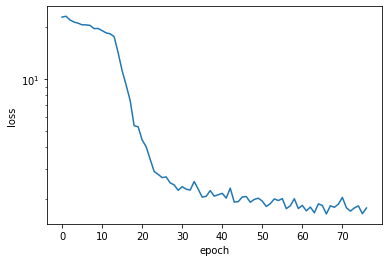

In [92]:
plt.figure()
plt.semilogy(history.history['loss'])
#plt.semilogy(history.history['val_loss'])
#plt.semilogy(history.history['lr'])
plt.xlabel('epoch'); plt.ylabel('loss')


In [93]:
tf.keras.models.save_model(model, filepath="D:\\OneDrive\\OneDrive - University of Massachusetts Dartmouth\\ECE457_Senior_Design_ECE5\\SavedModels\\MB\\Mar10_2022\\model_row42.h5")

In [ ]:
model = keras.models.load_model('model/')
#model = keras.models.load_model('model_3_13_22_epoch4/model/')
#model = keras.models.load_model(filepath="D:\\OneDrive\\OneDrive - University of Massachusetts Dartmouth\\ECE457_Senior_Design_ECE5\\SavedModels\\MB\\Mar10_2022\\model_row12.h5")

In [94]:
#trainpredicted=model.predict(train_inputs, verbose=1)
#valpredicted=model.predict(val_inputs, verbose=1)
#trainentirepredicted=model.predict(trainentire_inputs, verbose=1)
predicted038=model.predict(test_inputs, verbose=1)
predicted002=model.predict(test_inputs2, verbose=1)
#trainpredicted.shape, valpredicted.shape, predicted.shape, trainentirepredicted.shape

14437/14437 [==============================] - 70s 5ms/step


In [ ]:
predicted.shape, trainentirepredicted.shape

In [ ]:
port_abstraction_test_predicted=model.predict(abstraction_test_port_inputs, verbose=1)

In [ ]:
Yatest_port_scale
#val_targets
plt.figure(facecolor='white')
plt.plot(Yatest_port_scale[0:4278*3])
plt.plot(port_abstraction_test_predicted[0:4278*3])
plt.title("Port Abstraction Test (Actual vs. Predicted)")
plt.xlabel('Samples')
plt.ylabel('DOA in degrees')
plt.legend(['Actual','Predicted'])
plt.show()

In [ ]:
trainpredicted.shape, valpredicted.shape,trainpredicted.shape[0]+valpredicted.shape[0], predicted.shape, trainentirepredicted.shape

In [ ]:
predicted=model.predict(test_inputs, verbose=1)

In [ ]:
#val_targets
plt.figure(facecolor='white')
plt.plot(val_targets[0:2278*3])
plt.plot(valpredicted[0:2278*3])
plt.title("Validation (Actual vs. Predicted)")
plt.xlabel('Samples')
plt.ylabel('DOA in degrees')
plt.legend(['Actual','Predicted'])
plt.show()

In [ ]:
plt.figure(facecolor='white')
#plt.plot(y_train[0:2278*3])
plt.plot(y_train[0:80000])
#plt.plot(trainentirepredicted[0:2278*3])
plt.plot(trainentirepredicted[0:80000])
plt.title("Training (Actual vs. Predicted)")
plt.xlabel('Samples')
plt.ylabel('DOA in degrees')
plt.legend(['Actual','Predicted'])
plt.show()

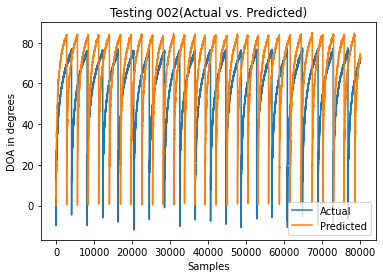

In [95]:
# Plot STBD Predicted for 002
zerosArray= np.arange(sequence_length)*0
predictedShifted=np.append(zerosArray, predicted002)
plt.figure(facecolor='white')
#plt.plot(y_test[0:4278*4])
plt.plot(y_test[0:80000])
#plt.plot(predictedShifted[0:4278*4])
plt.plot(predictedShifted[0:80000])
plt.title("Testing 002(Actual vs. Predicted)")
plt.xlabel('Samples')
plt.ylabel('DOA in degrees')
plt.legend(['Actual','Predicted'])
plt.show()



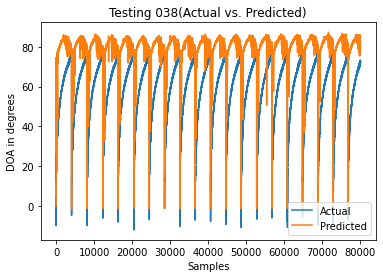

In [96]:
# Plot STBD Predicted for 038
zerosArray= np.arange(sequence_length)*0
predictedShifted=np.append(zerosArray, predicted038)
plt.figure(facecolor='white')
#plt.plot(y_test[0:4278*4])
plt.plot(y_test[0:80000])
#plt.plot(predictedShifted[0:4278*4])
plt.plot(predictedShifted[0:80000])
plt.title("Testing 038(Actual vs. Predicted)")
plt.xlabel('Samples')
plt.ylabel('DOA in degrees')
plt.legend(['Actual','Predicted'])
plt.show()

Using the Model, Predict the DOA's on the Testing Dataset

In [ ]:
#use the model to predict on the testing dataset
#for right now test_inputs has only the 40,001 samples
predicted=model.predict(test_inputs, verbose=1)

In [ ]:
predicted.shape

Put the predicted DOA's back into a csv file format

In [ ]:
#Ping |  Num Samp Num | PORT or STBD (0 or 1) |  TWTT |  Predicted DOA   <=======Output columns.
OutputCSVdf=test.iloc[:,[0,1,2,3]]
#OutputCSVdf= pd.DataFrame(test.iloc[:,[0,1,2,3]], columns=['PingNumber','SampNumber','PortStbd', 'SampleTime'])
zerosArray= np.arange(sequence_length)*0
predictedShifted=np.append(zerosArray, predicted)
Predicteddf= pd.DataFrame(predictedShifted,columns=['PredictedDOA'])
OutputCSVdf=OutputCSVdf.join(Predicteddf)

In [ ]:
OutputCSVdf.to_csv(path_or_buf="D:\\OneDrive\\OneDrive - University of Massachusetts Dartmouth\\ECE457_Senior_Design_ECE5\\AIOutput_CSV_Files\\mb_predictions\\PredictedOutputTestMB37.csv")

In [ ]:
PortOutputCSVdf=train.iloc[:,[0,1,2,3]]
#OutputCSVdf= pd.DataFrame(test.iloc[:,[0,1,2,3]], columns=['PingNumber','SampNumber','PortStbd', 'SampleTime'])
zerosArray= np.arange(sequence_length)*0
portPredictedShifted=np.append(zerosArray, trainentirepredicted)
portPredicteddf= pd.DataFrame(portPredictedShifted,columns=['PredictedDOA'])
PortOutputCSVdf=PortOutputCSVdf.join(portPredicteddf)
PortOutputCSVdf.to_csv(path_or_buf="D:\\OneDrive\\OneDrive - University of Massachusetts Dartmouth\\ECE457_Senior_Design_ECE5\\AIOutput_CSV_Files\\mb_predictions\\PredictedOutputTrainMB37.csv")

In [ ]:
StbdOriginalOutputCSVdf = test.iloc[:,[0,1,2,3,26]]
StbdOriginalOutputCSVdf.to_csv(path_or_buf="D:\\OneDrive\\OneDrive - University of Massachusetts Dartmouth\\ECE457_Senior_Design_ECE5\\AIOutput_CSV_Files\\mb_predictions\\Stbd_038_forEric.csv")
PortOriginalOutputCSVdf = train.iloc[:,[0,1,2,3,26]]
PortOriginalOutputCSVdf.to_csv(path_or_buf="D:\\OneDrive\\OneDrive - University of Massachusetts Dartmouth\\ECE457_Senior_Design_ECE5\\AIOutput_CSV_Files\\mb_predictions\\Port_038_forEric.csv")

In [ ]:
test.iloc[:,[0,1,2,3]]

In [ ]:
zerosArray= np.arange(sequence_length)*0
zerosArray

In [ ]:
predictedShifted=np.append(zerosArray, predicted)
predictedShifted

In [ ]:
OutputCSVdf

In [ ]:
print(predicted[0:21])

In [ ]:
print(y_test[10:21])

In [ ]:
type(predicted)
predicted.shape

In [ ]:
predicted_reshape= predicted.reshape(len(predicted),1)

In [ ]:
plt.figure(facecolor='white')
plt.plot(predicted[0:40000], 'orange')
plt.title("Actual")
plt.xlabel('Samples')
plt.ylabel('DOA in degrees')
plt.legend(['Predicted'])
plt.show()

Compare the Actual Testing DOA's to the Predicted DOA's

In [ ]:
plt.rcParams.update(plt.rcParamsDefault)


plt.figure(facecolor='white')
plt.plot(y_test[0:10], '.')
plt.plot(predicted[0:10], '.')
plt.title("Actual")
plt.legend(['Actual','Predicted'])
plt.xlabel('Samples')
plt.ylabel('DOA in degrees')
plt.show()

plt.figure(facecolor='white')
plt.plot(y_test[0:40000])
plt.plot(predicted_reshape[0:40000])
plt.title("Actual")
plt.xlabel('Samples')
plt.ylabel('DOA in degrees')
plt.legend(['Actual','Predicted'])
plt.show()


plt.figure(facecolor='white')
plt.plot(y_test[0:40000])
plt.title("Actual")
plt.xlabel('Samples')
plt.ylabel('DOA in degrees')
plt.legend(['Actual'])
plt.show()


plt.figure(facecolor='white')
plt.plot(predicted_reshape[0:40000], 'orange')
plt.title("Actual")
plt.xlabel('Samples')
plt.ylabel('DOA in degrees')
plt.legend(['Predicted'])
plt.show()


In [ ]:
print(y_test[0:50000])


In [ ]:
df2= pd.DataFrame(predicted, columns= ['DOA'])
df2